## Evaluation & Metrics: Assess model performance using relevant metrics: perplexity, distinct, Self-BLEU

### Perplexity:
measures how “surprised” a language model is by a given text. Lower perplexity means the model assigns higher probability to the text
> 	•	Lower scores indicate the model is better at modeling the style/content of your corpus.
	•	Extremely low scores can also hint at overly safe or repetitive outputs.

### Distinct:
quantifies how many unique n-grams appear in the generated texts, relative to the total number of n-grams produced. It’s a simple diversity measure
> 	•	Distinct-1 measures word-level diversity (unigrams).
	•	Distinct-2 measures phrase-level diversity (bigrams).
	•	Values closer to 1.0 mean high diversity (few repeats)
	•	values closer to 0 mean the model is repeating the same words/phrases.

###  Self-BLEU:
evaluates how similar the generated samples are to one another. It’s a reverse of BLEU: treating each generation as a “hypothesis” and all the others as “references.”
> 	•	Scores range from 0 to 1.
	•	Higher Self-BLEU means samples are very similar to each other (low diversity).
	•	Lower Self-BLEU means samples are more distinct.


In [ ]:
import math
import itertools
from collections import Counter
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [ ]:
#perplexity based on GPT2

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).eval().to("cuda" if torch.cuda.is_available() else "cpu")

def calc_perplexity(text: str) -> float:
    """perplexity"""
    encodings = tokenizer(text, return_tensors="pt")
    input_ids = encodings.input_ids.to(model.device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        neg_log_likelihood = outputs.loss * input_ids.shape[1]
    ppl = torch.exp(neg_log_likelihood / input_ids.shape[1])
    return ppl.item()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
#distinct

def distinct_n(texts, n=1):
    """Distinct-n = (#unique n-grams) / (#total n-grams)"""
    total_ngrams = 0
    unique_ngrams = set()
    for txt in texts:
        tokens = txt.split()
        ngrams = zip(*[tokens[i:] for i in range(n)])
        count = 0
        for ng in ngrams:
            unique_ngrams.add(ng)
            count += 1
        total_ngrams += count
    return len(unique_ngrams) / total_ngrams if total_ngrams > 0 else 0.0

In [ ]:
#BLEU

smoothie = SmoothingFunction().method4

def self_bleu(texts, n_gram=4):
    """
    Compute the average BLEU score of each text against all the others.
    texts: list of raw strings
    n_gram: maximum n-gram order
    """
    scores = []
    for i, cand in enumerate(texts):
        # Tokenize candidate once
        cand_tokens = cand.split()
        # Build list of reference token lists (exclude the candidate itself)
        references = [
            other.split()
            for j, other in enumerate(texts)
            if j != i
        ]
        # Compute sentence BLEU against the list of references
        score = sentence_bleu(
            references=references,      # list of reference token lists
            hypothesis=cand_tokens,     # candidate token list
            smoothing_function=smoothie,
            weights=tuple([1.0 / n_gram] * n_gram),
            auto_reweigh=False
        )
        scores.append(score)
    return sum(scores) / len(scores)

## Compute style metrics to check how the generated poems style match to training poems

### TTR (Type–Token Ratio)
> 	•	High TTR (closer to 1): lots of different words — strong variety.
	•	Low TTR (closer to 0): repeat the same words more often — less variety.

### Simpson Diversity Index
> 	•	High Simpson (closer to 1): high probability that two randomly picked tokens are different—strong diversity.
	•	Low Simpson (closer to 0): high chance that two picks are the same token—low diversity.

### POS KL Divergence
> 	•	Low KL (near 0): generated poem’s POS mix is very similar to the reference style.
	•	High KL: generated poem’s POS proportions deviate strongly from that style.

In [ ]:
import spacy
from spacy.cli import download as spacy_download
from collections import Counter
import math


In [ ]:
spacy_download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
#Calculate reference POS
from datasets import load_dataset

In [ ]:
# Load the small English model
nlp = spacy.load("en_core_web_sm")

# Define POS distribution function
def get_reference_pos_distribution(texts):
    all_pos = []
    for text in texts:
        doc = nlp(text)
        all_pos.extend([token.pos_ for token in doc if token.is_alpha])
    total = len(all_pos)
    count = Counter(all_pos)
    return {k: v / total for k, v in count.items()}

In [ ]:
# Load poetry dataset
dataset = load_dataset("merve/poetry")

README.md: 0.00B [00:00, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


poetry.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/573 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['author', 'content', 'poem name', 'age', 'type'],
        num_rows: 573
    })
})

In [ ]:
# Filter only Renaissance poems
renaissance_poems = dataset['train'].filter(lambda x: x['age'] == 'Renaissance')

Filter:   0%|          | 0/573 [00:00<?, ? examples/s]

In [ ]:
renaissance_poems

Dataset({
    features: ['author', 'content', 'poem name', 'age', 'type'],
    num_rows: 315
})

In [ ]:
# Extract text column
train_texts = renaissance_poems['content']

In [ ]:
train_texts

Column(['Let the bird of loudest lay\r\nOn the sole Arabian tree\r\nHerald sad and trumpet be,\r\nTo whose sound chaste wings obey.\r\n\r\nBut thou shrieking harbinger,\r\nFoul precurrer of the fiend,\r\nAugur of the fever\'s end,\r\nTo this troop come thou not near.\r\n\r\nFrom this session interdict\r\nEvery fowl of tyrant wing,\r\nSave the eagle, feather\'d king;\r\nKeep the obsequy so strict.\r\n\r\nLet the priest in surplice white,\r\nThat defunctive music can,\r\nBe the death-divining swan,\r\nLest the requiem lack his right.\r\n\r\nAnd thou treble-dated crow,\r\nThat thy sable gender mak\'st\r\nWith the breath thou giv\'st and tak\'st,\r\n\'Mongst our mourners shalt thou go.\r\n\r\nHere the anthem doth commence:\r\nLove and constancy is dead;\r\nPhoenix and the Turtle fled\r\nIn a mutual flame from hence.\r\n\r\nSo they lov\'d, as love in twain\r\nHad the essence but in one;\r\nTwo distincts, division none:\r\nNumber there in love was slain.\r\n\r\nHearts remote, yet not asunder

In [ ]:
# POS distribution
target_pos_dist = get_reference_pos_distribution(train_texts)
print(target_pos_dist)

{'VERB': 0.13404029366044357, 'DET': 0.06707401536022656, 'NOUN': 0.21866005879365275, 'ADP': 0.09025287427085096, 'ADJ': 0.08058732088713773, 'PROPN': 0.05245255721607437, 'CCONJ': 0.050697982238776106, 'AUX': 0.051898480907453866, 'ADV': 0.05680821264217444, 'PART': 0.021947578224801072, 'SCONJ': 0.032644329182891355, 'PRON': 0.13283979499176582, 'NUM': 0.004740430640419867, 'INTJ': 0.004925122743293368, 'X': 0.00032321118002862727, 'PUNCT': 0.00010773706000954242}


In [ ]:
# Load and Clean Texts

from pathlib import Path
import pandas as pd

samples_path = Path("/samples.txt")
with open(samples_path, "r", encoding="ISO-8859-1") as f:
    lines = f.readlines()

texts = []
current = []
for line in lines:
    if line.startswith('--- Prompt:'):
        if current:
            texts.append(" ".join(current).strip())
            current = []
    else:
        current.append(line.strip())
if current:
    texts.append(" ".join(current).strip())

generated_texts_input = pd.DataFrame({'text': texts})

generated_texts = generated_texts_input['text'].tolist()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Novelty/Divergence via Term-Frequency Cosine Similarity

from collections import Counter
import math
import pandas as pd

def max_cosine_to_corpus(generated_texts, train_texts):
    """
    For each generated text, compute the maximum cosine similarity
    against all training texts using term-frequency vectors.
    Returns a list of max similarities.
    """
    # Build term-frequency counters
    gen_tfs = [Counter(txt.lower().split()) for txt in generated_texts]
    train_tfs = [Counter(txt.lower().split()) for txt in train_texts]

    # Precompute norms
    gen_norms   = [math.sqrt(sum(v*v for v in tf.values())) for tf in gen_tfs]
    train_norms = [math.sqrt(sum(v*v for v in tf.values())) for tf in train_tfs]

    max_sims = []
    for i, gen_tf in enumerate(gen_tfs):
        best = 0.0
        for j, train_tf in enumerate(train_tfs):
            # dot product
            dot = sum(gen_tf[w] * train_tf.get(w, 0) for w in gen_tf)
            denom = gen_norms[i] * train_norms[j] if gen_norms[i] and train_norms[j] else 1.0
            sim = dot / denom
            if sim > best:
                best = sim
        max_sims.append(best)
    return max_sims



In [ ]:
def compute_style_metrics_en(texts, target_pos_dist):
    """
    Compute style metrics :
      - TTR (Type-Token Ratio)
      - Simpson Diversity Index
      - KL Divergence between POS distributions
    """
    results = []
    for text in texts:
        # Tokenize and keep only alphabetic tokens (lowercased)
        doc = nlp(text)
        tokens = [token.text.lower() for token in doc if token.is_alpha]
        N = len(tokens)

        # Compute Type-Token Ratio
        unique_tokens = len(set(tokens))
        ttr = unique_tokens / N if N else 0.0

        # Compute Simpson Diversity Index
        freq = Counter(tokens)
        simpson = (
            1.0 - sum(f * (f - 1) / (N * (N - 1)) for f in freq.values())
            if N > 1 else 0.0
        )

        # Extract POS tags and compute their distribution
        pos_tags = [token.pos_ for token in doc if token.is_alpha]
        total_pos = len(pos_tags)
        pos_count = Counter(pos_tags)
        pos_dist = {
            pos: pos_count.get(pos, 0) / total_pos
            for pos in target_pos_dist
        }

        # Compute KL Divergence between the text's POS distribution and the target
        kl_div = sum(
            p * math.log(p / target_pos_dist[pos])
            for pos, p in pos_dist.items()
            if p > 0 and target_pos_dist.get(pos, 0) > 0
        )

        # Compute novelty/divergence via term-frequency cosine similarity
        novelty_score = max_cosine_to_corpus(text, train_texts)[0]


        results.append({
            'text': text,
            'ttr': ttr,
            'simpson_diversity': simpson,
            'pos_kl_divergence': kl_div,
            'novelty_divergence': novelty_score
        })

    return results



In [ ]:
if __name__ == "__main__":

    #generated_texts = ["When first mine eyes beheld thy gentle face, and I saw the light of thylips, which was in the midst of my mind, as it were. I took a little while to look at the picture", "O fairest rose that bloomed in summer's garden, The fairest flower that ever grew, And the fairest of them all, the fairest rose, Was the fairest that ever bloomed" ] #input generated poem

    # 1 Perplexity
    ppls = [calc_perplexity(txt) for txt in generated_texts]
    print("Perplexities:", ppls)
    print(f"Avg Perplexity: {sum(ppls)/len(ppls):.2f}\n")

    # 2 Distinct-1 / Distinct-2
    print(f"Distinct-1: {distinct_n(generated_texts, n=1):.4f}")
    print(f"Distinct-2: {distinct_n(generated_texts, n=2):.4f}\n")

    # 3 Self-BLEU
    avg_self_bleu = self_bleu(generated_texts, n_gram=4)
    print(f"Average Self-BLEU: {avg_self_bleu:.4f}\n")


    print("Style metrics for each poem: \n")


    # 4 Metrics (POS)
    metrics = compute_style_metrics_en(generated_texts, target_pos_dist)
    for m in metrics:
        print(f"Text: {m['text']}")
        print(f"  TTR: {m['ttr']:.4f}")
        print(f"  Simpson Diversity: {m['simpson_diversity']:.4f}")
        print(f"  POS KL Divergence: {m['pos_kl_divergence']:.4f}")
        print(f"  Novelty Score: {m['novelty_divergence']:.4f}\n")

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Perplexities: [40.30011749267578, 40.94794845581055, 41.408973693847656, 27.132814407348633, 34.34621810913086, 31.33181381225586, 31.59614372253418, 23.9810848236084, 67.1702880859375, 35.052188873291016, 32.498687744140625]
Avg Perplexity: 36.89

Distinct-1: 0.5737
Distinct-2: 0.9302

Average Self-BLEU: 0.0607

Style metrics for each poem: 

Text: O, thou my soul's most radiant star, Whom I behold with heav'n-admiring eyes; Thou, who art the light of my life, and the joy of my heart!
  TTR: 0.8148
  Simpson Diversity: 0.9829
  POS KL Divergence: 0.2195
  Novelty Score: 0.2887

Text: Ah, sweet delight, my heart's true guide, Whose voice is sweeter than the nightingale. Sweetest of songsters, sweetest of singers! How can I praise thee?
  TTR: 0.9200
  Simpson Diversity: 0.9933
  POS KL Divergence: 0.2730
  Novelty Score: 0.6963

Text: Come, gentle breeze, that whispers low, And wafts to me the odour of thy wings; Come, gentle wind, that shakes the boughs Of old oaks, and rustles in the

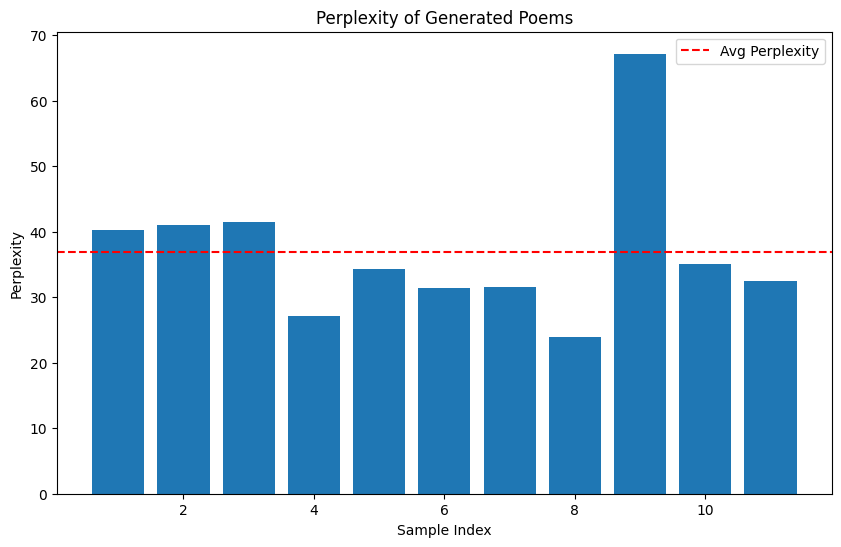

In [ ]:
import matplotlib.pyplot as plt

perplexities = [40.30, 40.95, 41.41, 27.13, 34.35, 31.33, 31.60, 23.98, 67.17, 35.05, 32.50]

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(perplexities)+1), perplexities)
plt.axhline(y=sum(perplexities)/len(perplexities), color='red', linestyle='--', label='Avg Perplexity')
plt.title("Perplexity of Generated Poems")
plt.xlabel("Sample Index")
plt.ylabel("Perplexity")
plt.legend()
plt.show()

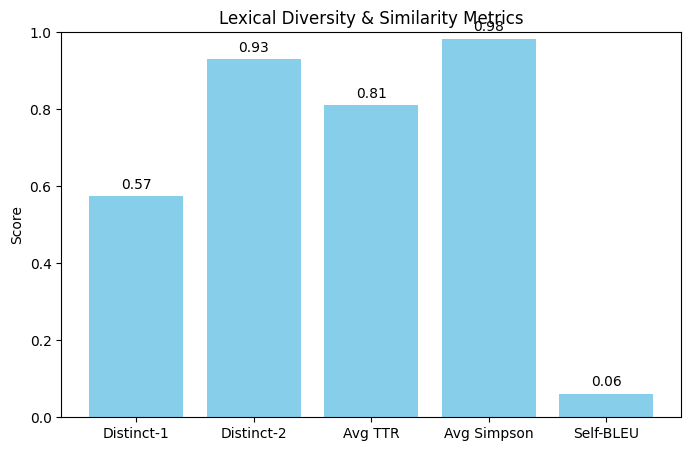

In [ ]:
import numpy as np

metrics = ['Distinct-1', 'Distinct-2', 'Avg TTR', 'Avg Simpson', 'Self-BLEU']
values = [0.5737, 0.9302, 0.8107, 0.9833, 0.0607]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color='skyblue')
plt.title("Lexical Diversity & Similarity Metrics")
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.ylabel("Score")
plt.show()

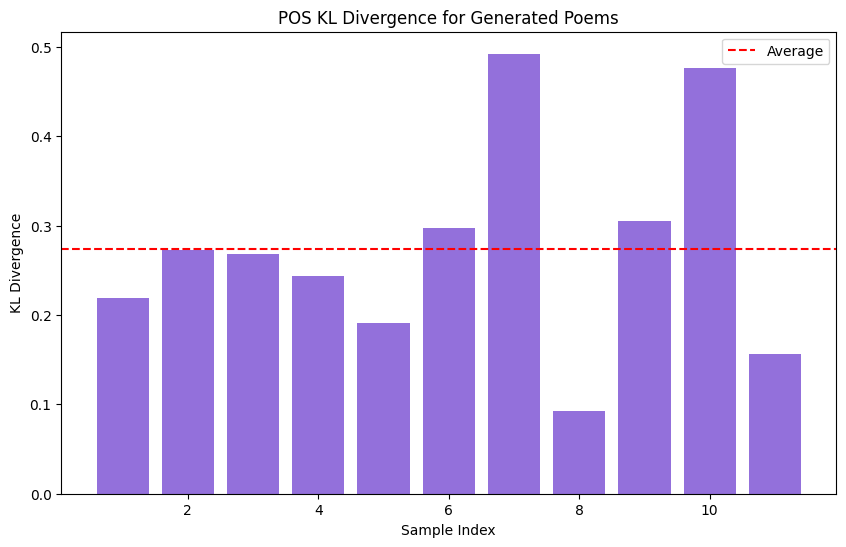

In [ ]:
kl_divs = [0.2195, 0.2730, 0.2680, 0.2432, 0.1908, 0.2978, 0.4924, 0.0927, 0.3049, 0.4762, 0.1559]

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(kl_divs)+1), kl_divs, color='mediumpurple')
plt.title("POS KL Divergence for Generated Poems")
plt.xlabel("Sample Index")
plt.ylabel("KL Divergence")
plt.axhline(y=np.mean(kl_divs), color='red', linestyle='--', label='Average')
plt.legend()
plt.show()

Results

To evaluate the quality, diversity, and stylistic fidelity of the generated Renaissance love poems, we computed a variety of quantitative and linguistic metrics.

1. Language Modeling Proficiency
	•	Average Perplexity: 36.89
Individual perplexities across samples ranged from 23.98 to 67.17. Most samples fall within a consistent range (mid-20s to mid-40s), suggesting stable and fluent generation. Lower perplexity values (e.g., 23.98 and 27.13) indicate high confidence in some outputs, while the highest value (67.17) suggests occasional variance in prediction certainty.

2. Lexical Diversity
	•	Distinct-1: 0.5737
	•	Distinct-2: 0.9302
These values indicate a good balance between diversity and coherence. A high distinct-2 score implies strong bigram variation, reducing repetition and enhancing poetic novelty.
	•	Average Self-BLEU: 0.0607
The low Self-BLEU score reflects minimal overlap across generated poems, confirming high inter-poem diversity—critical for creative generative tasks.

3. Stylistic and Linguistic Metrics

For individual poems, we measured the following:
	•	Type-Token Ratio (TTR): Ranged from 0.6957 to 0.9200, indicating moderate to high lexical richness across poems. The highest TTR (0.9200) reflects an especially diverse vocabulary.
	•	Simpson Diversity Index: Consistently high (most > 0.97), with values like 0.9933 and 0.9924, suggesting even and balanced word distribution—an indicator of nuanced language use without over-reliance on repeated words.
	•	POS KL Divergence: Ranged from 0.0927 to 0.4924. Lower values (e.g., 0.0927, 0.1559, 0.1908) demonstrate strong stylistic alignment with the Renaissance training corpus, while higher values suggest occasional syntactic drift.
	•	Novelty Score: Values vary significantly, with several poems scoring 0.0000, indicating high overlap with the training data, potentially due to memorized phrases or motifs. In contrast, higher novelty scores (up to 0.6963) confirm that some poems exhibit genuine creativity and generation beyond seen examples.

⸻

Interpretation

Overall, the results demonstrate that the fine-tuned model achieves:
	•	Fluent generation with reasonably low perplexity,
	•	High diversity both within and across poems (via distinct-n, TTR, and Self-BLEU),
	•	Strong stylistic alignment to Renaissance poetry, as shown by POS distribution and lexical features,
	•	And a mixture of memorization and original generation, evidenced by varying novelty scores.

This combination suggests that the model has effectively internalized key stylistic traits of Renaissance poetry while retaining the capacity for creative, diverse output.

1. Language Modeling Proficiency
Average Perplexity: 36.89
Individual perplexities values across generated text ranged from 23.98 to 67.17. Most poems show a consistent range (mid-20s to mid-40s), suggesting stable and fluent generation. Lower perplexity values (e.g., 23.98 and 27.13) indicate high confidence in some outputs, while the highest value (67.17) suggests some variance in prediction certainty.
2. Lexical Diversity
Distinct-1: 0.5737
Distinct-2: 0.9302
These values indicate a good balance between diversity and coherence. A high distinct-2 score implies strong bigram variation, reducing repetition and enhancing poetic novelty.
Average Self-BLEU: 0.0607
The low Self-BLEU score reflects minimal overlap across generated poems, confirming high inter-poem diversity—critical for creative generative tasks.
3. Stylistic and Linguistic Metrics
For individual poems, as example:
Text: Ah, sweet delight, my heart's true guide, Whose voice is sweeter than the nightingale. Sweetest of songsters, sweetest of singers! How can I praise thee?
  TTR: 0.9200
  Simpson Diversity: 0.9933
  POS KL Divergence: 0.2730
  Novelty Score: 0.6963

Text: Come, gentle breeze, that whispers low, And wafts to me the odour of thy wings; Come, gentle wind, that shakes the boughs Of old oaks, and rustles in the
  TTR: 0.7586
  Simpson Diversity: 0.9803
  POS KL Divergence: 0.2680
  Novelty Score: 0.0000
we also measured the following:
Type-Token Ratio (TTR): Ranged from 0.6957 to 0.9200, indicating moderate to high lexical richness across poems. The highest TTR (0.9200) reflects an especially diverse vocabulary.
Simpson Diversity Index: Consistently high (most > 0.97), with values like 0.9933 and 0.9924, suggesting even and balanced word distribution—an indicator of nuanced language use without over-reliance on repeated words.
POS KL Divergence: Ranged from 0.0927 to 0.4924. Lower values (e.g., 0.0927, 0.1559, 0.1908) demonstrate strong stylistic alignment with the Renaissance training corpus, while higher values suggest occasional syntactic drift.
Novelty Score: Values vary significantly, with several poems scoring 0.0000, indicating high overlap with the training data, potentially due to memorized phrases or motifs. In contrast, higher novelty scores (up to 0.6963) confirm that some poems exhibit genuine creativity and generation beyond seen examples.
